# Naive Bayes Classifier from Scratch
Implementation of Gaussian Naive Bayes classifier for Iris dataset classification

## 1. Data Loading & Exploration
Loading Iris dataset and initial exploration of features

In [23]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
import math

In [2]:
data = load_iris()
iris = pd.DataFrame(data.data,columns = data.feature_names)
species = pd.Series(data.target)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### Dataset Structure
The Iris dataset contains 4 features:
1. Sepal length (cm)
2. Sepal width (cm)
3. Petal length (cm)
4. Petal width (cm)

With 3 target classes:
- 0: Iris Setosa
- 1: Iris Versicolour
- 2: Iris Virginica

## 2. Feature Selection
Using correlation analysis to select independent features

<Axes: >

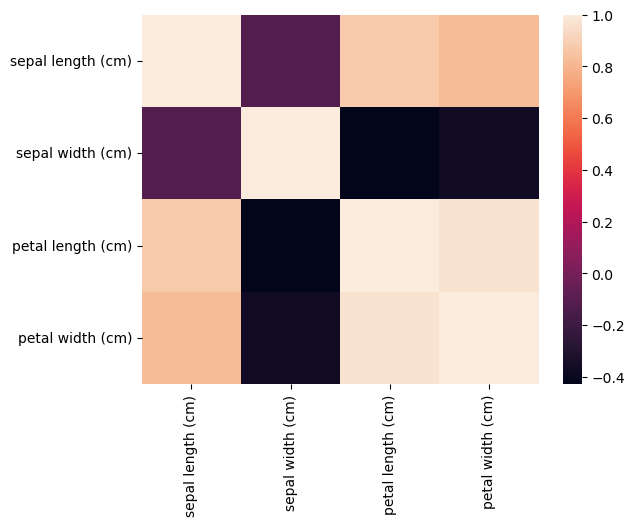

In [3]:
sns.heatmap(iris.corr())

**Feature Selection Rationale**:
- High correlation between (petal length & petal width) and (sepal length & petal length)
- Selected features with low correlation:
  - Sepal width (cm)
  - Petal length (cm)


In [4]:
iris.drop(columns = ["sepal length (cm)","petal width (cm)"],inplace=True)

## 3. Data Preprocessing
Splitting data into training and test sets (73-27 split)

In [5]:
iris.describe()

,sepal width (cm),petal length (cm)
count,150.000000,150.000000
mean,3.057333,3.758000
std,0.435866,1.765298
min,2.000000,1.000000
25%,2.800000,1.600000
50%,3.000000,4.350000
75%,3.300000,5.100000
max,4.400000,6.900000


<Axes: xlabel='petal length (cm)', ylabel='Count'>

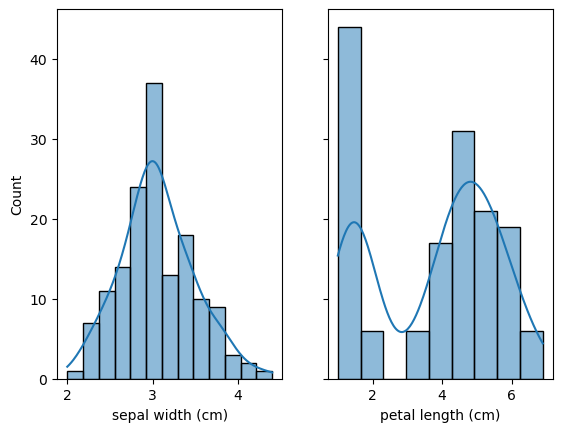

In [6]:
fig , axes = plt.subplots(1,2,sharey=True)
sns.histplot(iris , ax=axes[0] , x = 'sepal width (cm)' , kde=True)
sns.histplot(iris , ax=axes[1] , x = 'petal length (cm)' , kde=True)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(
    iris,species, test_size=0.27, random_state=42,shuffle=True)

## 4. Naive Bayes Implementation

### 4.1 Prior Probability Calculation
Calculates class prior probabilities using:
$$ P(y=c) = \frac{N_c}{N} $$
Where:
- \( N_c \) = Number of instances in class c
- \( N \) = Total number of instances

In [8]:
def calculate_prior(y_train):
    classes,counts = np.unique(y_train,return_counts=True)
    priors = counts/sum(counts)
    return priors

In [9]:
for c in np.unique(y_train):
    unique_values = X_train.loc[y_train == c, "sepal width (cm)"].unique()

### 4.2 Gaussian Parameters Calculation
Calculates mean (μ) and standard deviation (σ) for each feature per class:
$$ \mu_{c,i} = \frac{1}{N_c} \sum_{x \in c} x_i $$
$$ \sigma_{c,i} = \sqrt{\frac{1}{N_c} \sum_{x \in c} (x_i - \mu_{c,i})^2} $$

In [10]:
def calculate_mean_var_byclass(X_train,y_train,i,c):
    mean = X_train.loc[y_train == c, X_train.columns[i]].mean()
    std= X_train.loc[y_train == c, X_train.columns[i]].std()
  
    return mean,std

### 4.3 Likelihood Calculation
Computes Gaussian probability density using:
$$ P(x_i | y=c) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x_i - \mu)^2}{2\sigma^2}} $$
Handles numerical stability by setting minimum σ threshold

In [11]:
def calculate_likelihood(X_train, val, i, c):
    mean, std = calculate_mean_var_byclass(X_train, y_train, i, c)

    

    if std <= 1e-6:  # Check for very small standard deviation
        std = 1e-6  # Assign a reasonable minimum std to avoid large p(x)
    
  
    p = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((val - mean) ** 2) / (2 * std ** 2))
    
    
    return p

In [14]:
classes = species.unique()
classes

array([0, 1, 2])

### 4.4 Posterior Calculation & Prediction
Implements Naive Bayes classification using:
$$ P(y=c | x) \propto P(y=c) \prod_{i=1}^n P(x_i | y=c) $$
Returns class with maximum posterior probability

In [15]:
def naive_bayesian_gaussian(X_train,y_train,val):
    priors = calculate_prior(y_train)
    n= X_train.shape[1]
    likelihood=np.zeros(len(classes))
    for c in classes:
        p=1
        for i in range(n):
            p*=calculate_likelihood(X_train,val.iloc[i],i,c)
        likelihood[c]=p

    posterior=priors*likelihood 
    return np.argmax(posterior)
            

In [16]:
naive_bayesian_gaussian(X_train,y_train,X_test.iloc[19])

2

## 5. Model Evaluation
Testing classifier performance on test set

In [17]:
def prediction(X_train,y_train,X_test):
    n=y_test.shape[0]
    preds=np.zeros(n)
    for x in range(n):
        preds[x]=naive_bayesian_gaussian(X_train,y_train,X_test.iloc[x])
    return preds   

In [18]:
preds = prediction(X_train,y_train,X_test)

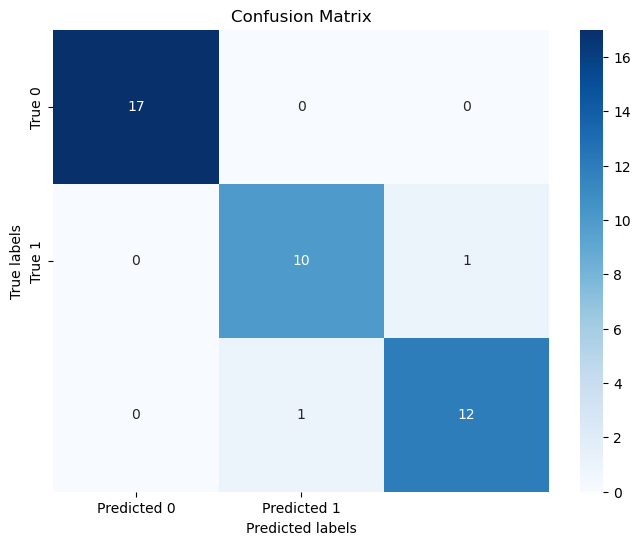

In [25]:
cm = confusion_matrix(y_test.to_numpy(), preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()